In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
import torchvision
from torch.utils.data import DataLoader
from torchvision import models,datasets,transforms
from leakageFuncs import Network, trainAndReleaseGrads
batchSize=1

In [2]:
trainL = datasets.MNIST("./data",train=True,download=True,transform=transforms.Compose([transforms.ToTensor(),
       transforms.Normalize((0.13707,),(.3081,))]))
trainData = enumerate(DataLoader(trainL,batch_size=batchSize,shuffle=True))

testL = datasets.MNIST("./data",train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),
       transforms.Normalize((0.13707,),(.3081,))]))
testData = enumerate(DataLoader(testL,batch_size=batchSize,shuffle=True))

In [3]:
model = Network()

In [4]:
model

Network(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=57600, out_features=10, bias=True)
  )
)

In [5]:
opt = torch.optim.SGD(model.parameters(),lr=1e-3)
crit = nn.CrossEntropyLoss()

In [6]:
model, grad = trainAndReleaseGrads(model,trainData,5000,nn.CrossEntropyLoss(),torch.optim.SGD(model.parameters(),lr=1e-3))

Example: 0, loss: 2.3317248821258545
Example: 1000, loss: 0.8306520581245422
Example: 2000, loss: 3.3506569862365723
Example: 3000, loss: 0.4169065058231354
Example: 4000, loss: 1.7832446098327637
Example: 5000, loss: 0.756360650062561


In [25]:

x = torch.randn(trainL.data[0].shape)
y = torch.randn(10)
toImage = transforms.ToPILImage()

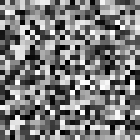

In [31]:
#our image to start
im = toImage(x)
display(im.resize((5 * 28, 5 * 28), Image.NEAREST))